## Before and After Analysis

In [1]:
# import libraries

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Loading casualty data

In [2]:
# load casualties for 2018 and 2022
casualty_2022 = pd.read_csv('data/jan-dec-2022-gla-data-extract-casualties.csv')
casualty_2018 = pd.read_csv('data/2018-data-files-casualty.csv')

In [19]:
# filter by casualty severity

casualty_2018 = casualty_2018[casualty_2018['Casualty Severity'] != '3 Slight'].copy()
casualty_2022 = casualty_2022[casualty_2022['_Casualty Severity'] != 'Slight'].copy()

In [20]:
casualty_2018.head(1)

,Accident Ref.,Borough,Boro,Easting,Northing,CREFNO,Casualty Class,Casualty Sex,Casualty Age (Banded),Casualty Age,No. of Casualties,Casualty Severity,Ped. Location,Ped. Movement,Mode of Travel,
12,1180133621,CITY OF LONDON,0,531200,180810,1,3 Pedestrian,1 Male,25-59,47,1,2 Serious,05 Crossing Road (Not On Xing),4 From Drivers O/Side Msk,1 Pedestrian,


In [21]:
# make a GeoPandas GeoDataFrame
casualty_2018_gdf = gpd.GeoDataFrame(
    casualty_2018,
    geometry = gpd.points_from_xy(casualty_2018['Easting'], casualty_2018['Northing'], crs = 'EPSG:27700')
)

casualty_2022_gdf = gpd.GeoDataFrame(
    casualty_2022,
    geometry = gpd.points_from_xy(casualty_2022['Easting'], casualty_2022['Northing'], crs = 'EPSG:27700')
)



### Merging with Geographic Data

In [58]:
# load Borough data
boroughs = gpd.read_file('data/boundary/London_Borough_Excluding_MHW.shp').to_crs('EPSG:27700')
msoa = gpd.read_file('data/boundary/MSOA_2011_London_gen_MHW.shp').to_crs('EPSG:27700')


#### Merging with Borough Data

In [59]:
# summarise by borough
casualty_boro_2018 = pd.DataFrame(
    boroughs.sjoin(
        casualty_2018_gdf,
        predicate = 'intersects'
    ).groupby('GSS_CODE')['No. of Casualties'].sum()
).rename(columns = {'No. of Casualties': 'casualty_2018'})

casualty_boro_2022 = pd.DataFrame(
    boroughs.sjoin(
        casualty_2022_gdf,
        predicate = 'intersects'
    ).groupby('GSS_CODE')['_Casualty Count'].sum()
).rename(columns = {'_Casualty Count': 'casualty_2022'})


In [60]:
# merge data

boroughs = boroughs.merge(
    casualty_boro_2018, left_on = 'GSS_CODE', right_index = True
).merge(
    casualty_boro_2022, left_on = 'GSS_CODE', right_index = True
)

In [98]:
# get difference between 2022 and 2018
boroughs['casualty_difference'] = np.log(boroughs['casualty_2022'] / boroughs['casualty_2018'])

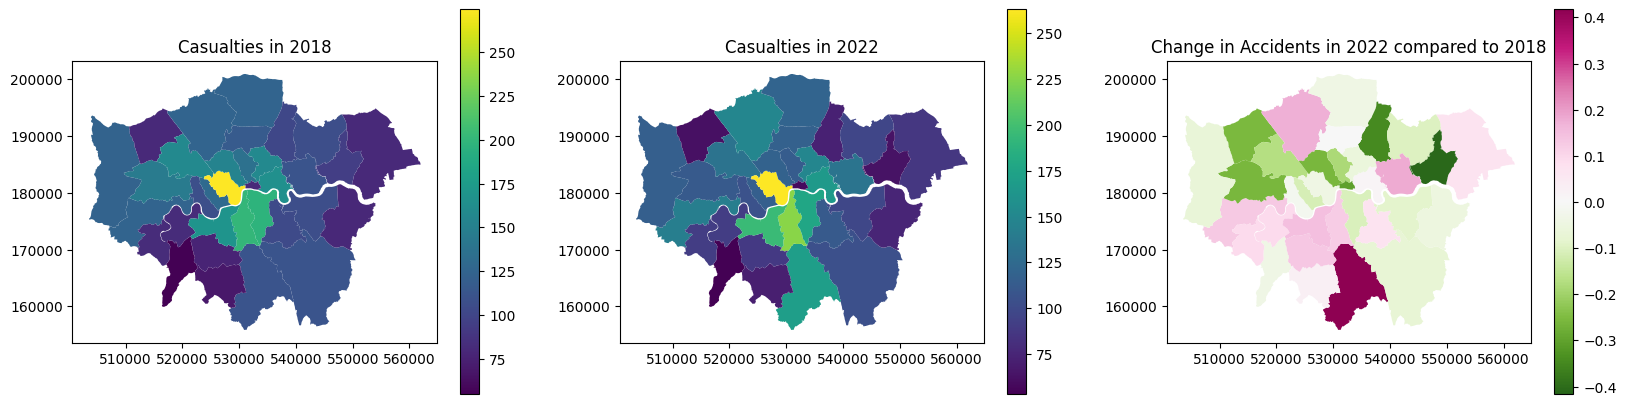

In [110]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))

boroughs.plot(
    ax = axes[0],
    column = 'casualty_2018',
    legend = True
)
axes[0].set_title('Casualties in 2018')

boroughs.plot(
    ax = axes[1],
    column = 'casualty_2022',
    legend = True
)
axes[1].set_title('Casualties in 2022')

boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)].plot(
    ax = axes[2],
    column = 'casualty_difference',
    legend = True,
    cmap = 'PiYG_r',
    vmin = -max(abs(boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)]['casualty_difference'])),
    vmax = max(abs(boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)]['casualty_difference'])),
)
axes[2].set_title('Change in Accidents in 2022 compared to 2018')

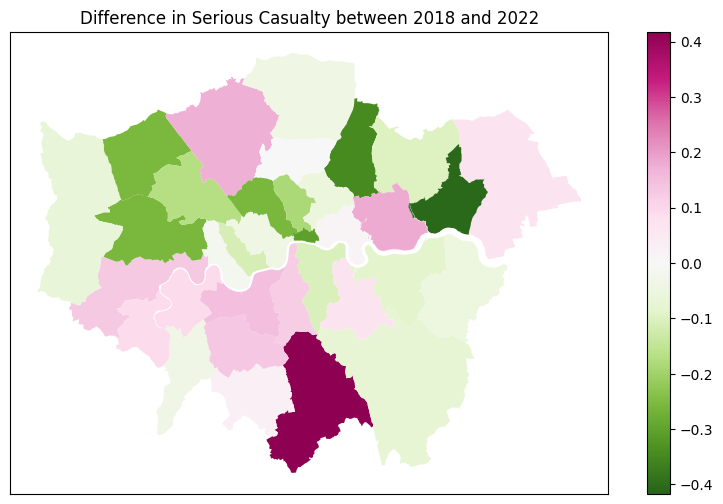

In [163]:
# plot for difference in casualty

# initialise plot
f, ax = plt.subplots(1, 1, figsize = (10, 6))

# plot boroughs
boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)].plot(
    ax = ax,
    column = 'casualty_difference',
    legend = True,
    cmap = 'PiYG_r',
    vmin = -max(abs(boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)]['casualty_difference'])),
    vmax = max(abs(boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)]['casualty_difference'])),
)

# set title
plt.title('Difference in Serious Casualty between 2018 and 2022')

# delete axis ticks
plt.xticks([])
plt.yticks([])

# save figure
plt.savefig('plots/casualty_difference.png', bbox_inches = 'tight')

In [132]:
borough_name = 'Kensington and Chelsea'
boroughs[boroughs['NAME'] == borough_name].geometry.bounds.minx.iloc[0]

522964.299963096

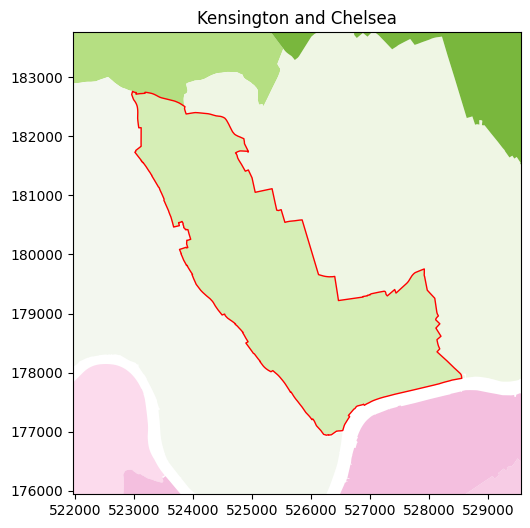

In [154]:
borough_name = 'Kensington and Chelsea'
margin = 1000
bbox = boroughs[boroughs['NAME'] == borough_name].geometry.bounds

fig, ax = plt.subplots(1,1,figsize = (8,6))

boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)].plot(
    ax = ax,
    column = 'casualty_difference',
    # legend = True,
    cmap = 'PiYG_r',
    vmin = -max(abs(boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)]['casualty_difference'])),
    vmax = max(abs(boroughs[(boroughs['casualty_2018'] != 0) & (boroughs['casualty_2022'] != 0)]['casualty_difference'])),
)

boroughs[boroughs['NAME'] == borough_name].plot(
    ax = ax,
    edgecolor = 'red',
    facecolor = 'None'
)

plt.xlim(bbox.minx.iloc[0] - margin, bbox.maxx.iloc[0] + margin)
plt.ylim(bbox.miny.iloc[0] - margin, bbox.maxy.iloc[0] + margin)

plt.title(f'{borough_name}')

plt.show()

#### Merging with MSOA

In [64]:
# summarise by msoa
casualty_msoa_2018 = pd.DataFrame(
    msoa.sjoin(
        casualty_2018_gdf,
        predicate = 'intersects',
        how = 'left'
    ).groupby('MSOA11CD')['No. of Casualties'].sum()
).rename(columns = {'No. of Casualties': 'casualty_2018'})

casualty_msoa_2022 = pd.DataFrame(
    msoa.sjoin(
        casualty_2022_gdf,
        predicate = 'intersects',
        how = 'left'
    ).groupby('MSOA11CD')['_Casualty Count'].sum()
).rename(columns = {'_Casualty Count': 'casualty_2022'})


In [65]:
# merge data
msoa = msoa.merge(
    casualty_msoa_2018, left_on = 'MSOA11CD', right_index = True
).merge(
    casualty_msoa_2022, left_on = 'MSOA11CD', right_index = True
)

In [92]:
# get difference between 2022 and 2018
msoa['casualty_difference'] = np.log(msoa['casualty_2022'] / msoa['casualty_2018'])


c:\Users\Soki\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


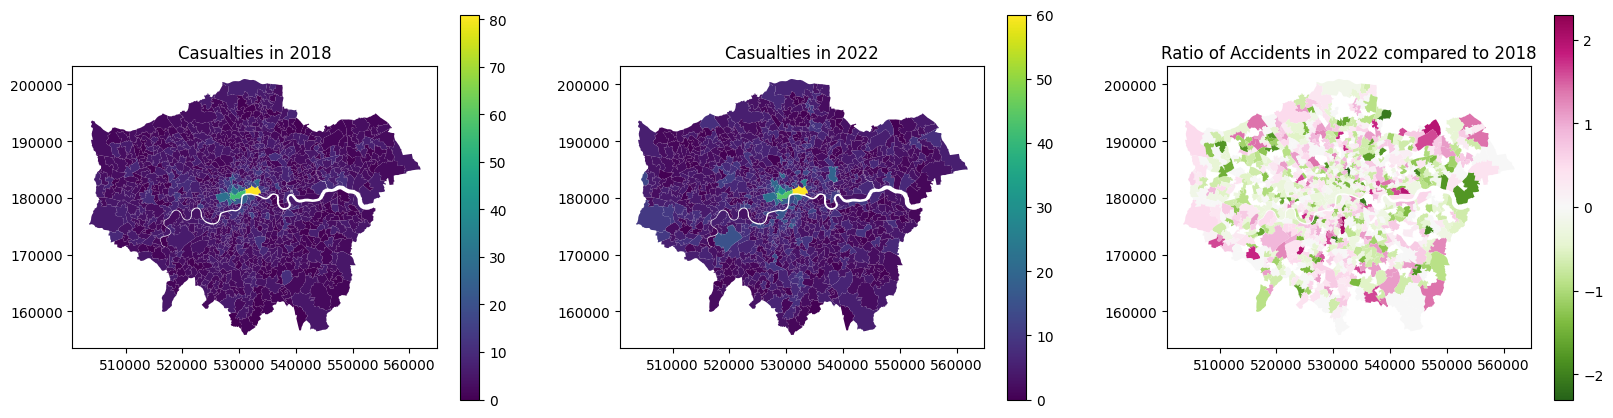

In [107]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))

msoa.plot(
    ax = axes[0],
    column = 'casualty_2018',
    legend = True
)
axes[0].set_title('Casualties in 2018')

msoa.plot(
    ax = axes[1],
    column = 'casualty_2022',
    legend = True
)
axes[1].set_title('Casualties in 2022')

msoa[(msoa['casualty_2018'] != 0) & (msoa['casualty_2022'] != 0)].plot(
    ax = axes[2],
    column = 'casualty_difference',
    legend = True,
    cmap = 'PiYG_r',
    vmin=-max(abs(msoa[(msoa['casualty_2018'] != 0) & (msoa['casualty_2022'] != 0)]['casualty_difference'])),
    vmax=max(abs(msoa[(msoa['casualty_2018'] != 0) & (msoa['casualty_2022'] != 0)]['casualty_difference']))
    
)
axes[2].set_title('Ratio of Accidents in 2022 compared to 2018')

plt.show()


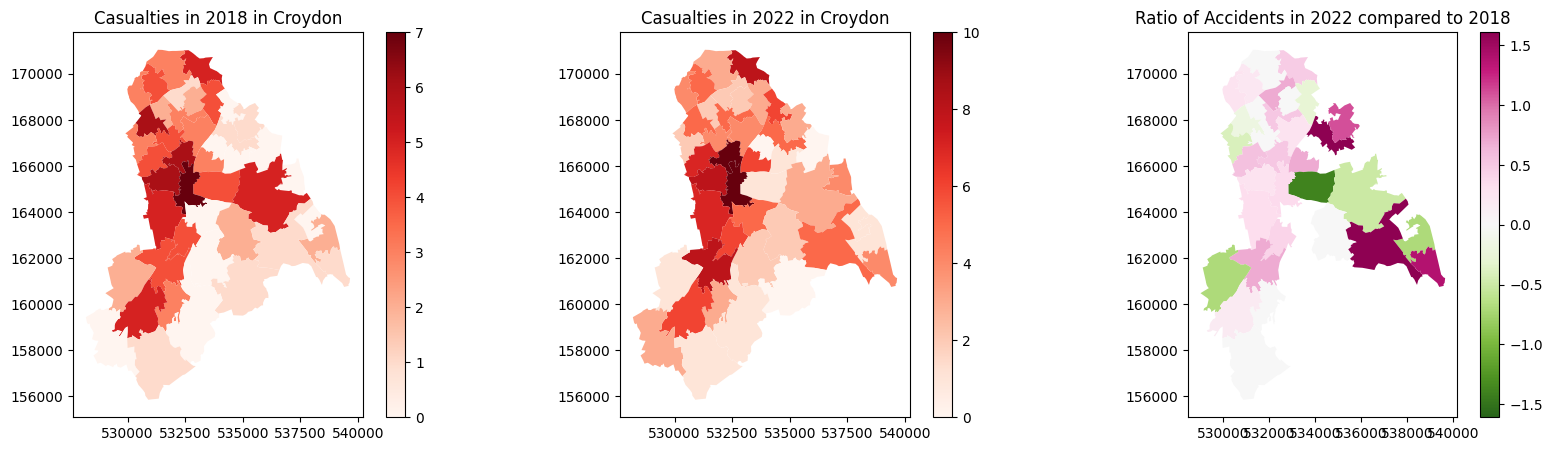

In [152]:
# extract a borough

borough = 'Croydon'

fig, axes = plt.subplots(1, 3, figsize = (20, 5))

msoa[msoa['LAD11NM'] == borough].plot(
    ax = axes[0],
    column = 'casualty_2018',
    legend = True,
    cmap = 'Reds'
)
axes[0].set_title(f'Casualties in 2018 in {borough}')

msoa[msoa['LAD11NM'] == borough].plot(
    ax = axes[1],
    column = 'casualty_2022',
    legend = True,
    cmap = 'Reds'
)
axes[1].set_title(f'Casualties in 2022 in {borough}')

msoa[(msoa['casualty_2018'] != 0) & (msoa['casualty_2022'] != 0) & (msoa['LAD11NM'] == borough)].plot(
    ax = axes[2],
    column = 'casualty_difference',
    legend = True,
    cmap = 'PiYG_r',
    vmin=-max(abs(msoa[(msoa['casualty_2018'] != 0) & (msoa['casualty_2022'] != 0) & (msoa['LAD11NM'] == borough)]['casualty_difference'])),
    vmax=max(abs(msoa[(msoa['casualty_2018'] != 0) & (msoa['casualty_2022'] != 0) & (msoa['LAD11NM'] == borough)]['casualty_difference']))
)

axes[2].set_title('Ratio of Accidents in 2022 compared to 2018')

plt.show()

,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,casualty_2018,casualty_2022,casualty_difference
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647....",81.0,60.0,0.740741
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19...",1.0,2.0,2.000000
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18...",3.0,6.0,2.000000
3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18...",3.0,1.0,0.333333
4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18...",2.0,3.0,1.500000
